In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 128

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalAvgPool1D()(output) for output in layer_outputs[-2:]])
    x = BatchNormalization()(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 128)   768         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 128)   512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 128)   0           batch_normalization_v1[0][0]     
_____________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 128)   768         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_9 (Batch (None, 16000, 128)   512         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 128)   0           batch_normalization_v1_9[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 128)   768         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_22 (Batc (None, 16000, 128)   512         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_22[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6156 - acc: 0.5109
Epoch 00001: val_loss improved from inf to 1.87797, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_BN_3_conv_checkpoint/001-1.8780.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 1.6156 - acc: 0.5109 - val_loss: 1.8780 - val_acc: 0.4277
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2910 - acc: 0.6175
Epoch 00002: val_loss did not improve from 1.87797
36805/36805 [==============================] - 103s 3ms/sample - loss: 1.2910 - acc: 0.6175 - val_loss: 1.9198 - val_acc: 0.3739
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1707 - acc: 0.6551
Epoch 00003: val_loss improved from 1.87797 to 1.61310, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_BN_3_conv_checkpoint/003-1.61

36800/36805 [============================>.] - ETA: 0s - loss: 0.7074 - acc: 0.7942
Epoch 00027: val_loss did not improve from 0.95458
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.7075 - acc: 0.7942 - val_loss: 1.2163 - val_acc: 0.6506
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6965 - acc: 0.7957
Epoch 00028: val_loss did not improve from 0.95458
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.6965 - acc: 0.7957 - val_loss: 1.0083 - val_acc: 0.6762
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6927 - acc: 0.7980
Epoch 00029: val_loss did not improve from 0.95458
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.6927 - acc: 0.7980 - val_loss: 1.3884 - val_acc: 0.6252
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6875 - acc: 0.7993
Epoch 00030: val_loss improved from 0.95458 to 0.90804, saving model to model/checkpo

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5654 - acc: 0.8365
Epoch 00056: val_loss did not improve from 0.81417
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.5654 - acc: 0.8365 - val_loss: 2.4520 - val_acc: 0.4218
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5608 - acc: 0.8384
Epoch 00057: val_loss did not improve from 0.81417
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.5609 - acc: 0.8384 - val_loss: 0.9160 - val_acc: 0.7277
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5628 - acc: 0.8366
Epoch 00058: val_loss did not improve from 0.81417
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.5631 - acc: 0.8366 - val_loss: 2.1178 - val_acc: 0.5083
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5572 - acc: 0.8371
Epoch 00059: val_loss did not improve from 0.81417
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.4843 - acc: 0.8601
Epoch 00085: val_loss did not improve from 0.78755
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.4843 - acc: 0.8601 - val_loss: 1.2753 - val_acc: 0.6401
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4800 - acc: 0.8585
Epoch 00086: val_loss did not improve from 0.78755
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.4801 - acc: 0.8584 - val_loss: 1.3881 - val_acc: 0.6191
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4780 - acc: 0.8603
Epoch 00087: val_loss did not improve from 0.78755
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.4779 - acc: 0.8603 - val_loss: 0.9362 - val_acc: 0.7372
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4759 - acc: 0.8610
Epoch 00088: val_loss did not improve from 0.78755
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.4185 - acc: 0.8795
Epoch 00114: val_loss did not improve from 0.69096
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.4185 - acc: 0.8795 - val_loss: 1.1645 - val_acc: 0.6855
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4184 - acc: 0.8817
Epoch 00115: val_loss did not improve from 0.69096
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.4184 - acc: 0.8816 - val_loss: 1.4936 - val_acc: 0.6154
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4125 - acc: 0.8793
Epoch 00116: val_loss did not improve from 0.69096
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.4125 - acc: 0.8793 - val_loss: 2.8652 - val_acc: 0.4819
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4085 - acc: 0.8824
Epoch 00117: val_loss did not improve from 0.69096
36805/36805 [==================

Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3632 - acc: 0.8953
Epoch 00144: val_loss did not improve from 0.69096
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.3636 - acc: 0.8952 - val_loss: 1.4682 - val_acc: 0.6336
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3588 - acc: 0.8962
Epoch 00145: val_loss did not improve from 0.69096
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.3588 - acc: 0.8962 - val_loss: 2.0248 - val_acc: 0.5600
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3562 - acc: 0.8961
Epoch 00146: val_loss did not improve from 0.69096
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.3565 - acc: 0.8960 - val_loss: 1.6316 - val_acc: 0.5973
Epoch 147/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3575 - acc: 0.8968
Epoch 00147: val_loss did not improve from 0.69096
36805/36805 [====

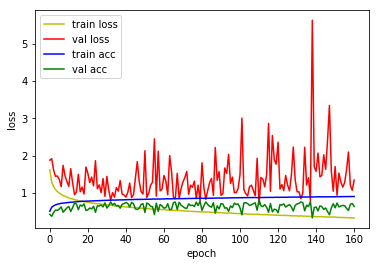

4815/4815 [==============================] - 5s 996us/sample - loss: 0.8053 - acc: 0.7711
Loss: 0.8053225175118768 Accuracy: 0.7711319

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4705 - acc: 0.5520
Epoch 00001: val_loss improved from inf to 1.65542, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_BN_4_conv_checkpoint/001-1.6554.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 1.4705 - acc: 0.5520 - val_loss: 1.6554 - val_acc: 0.4899
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0948 - acc: 0.6745
Epoch 00002: val_loss improved from 1.65542 to 1.13865, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_BN_4_conv_checkpoint/002-1.1387.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 1.0949 - acc: 0.6745 - val_loss: 1.1387 - val_acc: 0.6580
Epoch 3/500
36800/36805 [==========================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4562 - acc: 0.8724
Epoch 00027: val_loss did not improve from 0.76469
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.4562 - acc: 0.8724 - val_loss: 1.1508 - val_acc: 0.6529
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4412 - acc: 0.8780
Epoch 00028: val_loss improved from 0.76469 to 0.72785, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_BN_4_conv_checkpoint/028-0.7279.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.4413 - acc: 0.8780 - val_loss: 0.7279 - val_acc: 0.8039
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4343 - acc: 0.8783
Epoch 00029: val_loss did not improve from 0.72785
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.4343 - acc: 0.8783 - val_loss: 1.0979 - val_acc: 0.6646
Epoch 30/500
36800/36805 [============================>.] - E

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2659 - acc: 0.9268
Epoch 00056: val_loss did not improve from 0.58315
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.2658 - acc: 0.9268 - val_loss: 0.8678 - val_acc: 0.7531
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2628 - acc: 0.9282
Epoch 00057: val_loss did not improve from 0.58315
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.2628 - acc: 0.9282 - val_loss: 0.7862 - val_acc: 0.7885
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2585 - acc: 0.9306
Epoch 00058: val_loss did not improve from 0.58315
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.2585 - acc: 0.9306 - val_loss: 1.3267 - val_acc: 0.6622
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2565 - acc: 0.9289
Epoch 00059: val_loss did not improve from 0.58315
36805/36805 [========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1610 - acc: 0.9570
Epoch 00086: val_loss did not improve from 0.58315
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.1611 - acc: 0.9570 - val_loss: 0.6118 - val_acc: 0.8460
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1560 - acc: 0.9595
Epoch 00087: val_loss did not improve from 0.58315
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.1563 - acc: 0.9595 - val_loss: 1.0600 - val_acc: 0.7400
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1516 - acc: 0.9613
Epoch 00088: val_loss did not improve from 0.58315
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.1516 - acc: 0.9613 - val_loss: 1.5011 - val_acc: 0.6553
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1484 - acc: 0.9604
Epoch 00089: val_loss did not improve from 0.58315
36805/36805 [========

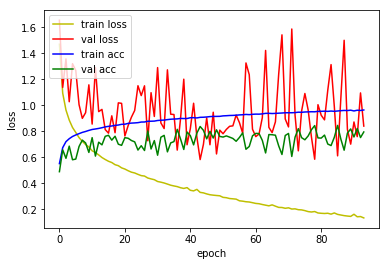

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.6988 - acc: 0.8019
Loss: 0.6988116537299112 Accuracy: 0.80186915

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2644 - acc: 0.6194
Epoch 00001: val_loss improved from inf to 1.46668, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_BN_5_conv_checkpoint/001-1.4667.hdf5
36805/36805 [==============================] - 114s 3ms/sample - loss: 1.2643 - acc: 0.6195 - val_loss: 1.4667 - val_acc: 0.5714
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8239 - acc: 0.7677
Epoch 00002: val_loss improved from 1.46668 to 0.84374, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_BN_5_conv_checkpoint/002-0.8437.hdf5
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.8238 - acc: 0.7677 - val_loss: 0.8437 - val_acc: 0.7659
Epoch 3/500
36800/36805 [===========================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1643 - acc: 0.9547
Epoch 00027: val_loss improved from 0.39046 to 0.37174, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_BN_5_conv_checkpoint/027-0.3717.hdf5
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1645 - acc: 0.9546 - val_loss: 0.3717 - val_acc: 0.8970
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1636 - acc: 0.9558
Epoch 00028: val_loss did not improve from 0.37174
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1636 - acc: 0.9558 - val_loss: 0.3897 - val_acc: 0.8915
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1436 - acc: 0.9610
Epoch 00029: val_loss did not improve from 0.37174
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1437 - acc: 0.9610 - val_loss: 0.5430 - val_acc: 0.8640
Epoch 30/500
36800/36805 [============================>.] - E

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0509 - acc: 0.9889
Epoch 00056: val_loss did not improve from 0.34440
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0509 - acc: 0.9889 - val_loss: 0.5691 - val_acc: 0.8623
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0565 - acc: 0.9867
Epoch 00057: val_loss did not improve from 0.34440
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0566 - acc: 0.9867 - val_loss: 0.6010 - val_acc: 0.8546
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0575 - acc: 0.9863
Epoch 00058: val_loss did not improve from 0.34440
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0580 - acc: 0.9863 - val_loss: 0.4494 - val_acc: 0.8873
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0631 - acc: 0.9849
Epoch 00059: val_loss did not improve from 0.34440
36805/36805 [========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9947
Epoch 00085: val_loss did not improve from 0.31801
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0261 - acc: 0.9947 - val_loss: 0.4449 - val_acc: 0.9003
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0235 - acc: 0.9953
Epoch 00086: val_loss did not improve from 0.31801
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0236 - acc: 0.9953 - val_loss: 0.5510 - val_acc: 0.8803
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0430 - acc: 0.9901
Epoch 00087: val_loss did not improve from 0.31801
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0430 - acc: 0.9901 - val_loss: 0.4980 - val_acc: 0.8928
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0199 - acc: 0.9964
Epoch 00088: val_loss did not improve from 0.31801
36805/36805 [========

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.9970
Epoch 00115: val_loss did not improve from 0.31801
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0179 - acc: 0.9970 - val_loss: 0.5990 - val_acc: 0.8873
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9977
Epoch 00116: val_loss did not improve from 0.31801
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0134 - acc: 0.9977 - val_loss: 1.0907 - val_acc: 0.7831
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0198 - acc: 0.9959
Epoch 00117: val_loss did not improve from 0.31801
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.0199 - acc: 0.9959 - val_loss: 0.5686 - val_acc: 0.8831
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0250 - acc: 0.9944
Epoch 00118: val_loss did not improve from 0.31801
36805/36805 [====

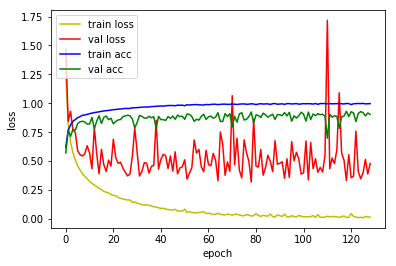

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3680 - acc: 0.9057
Loss: 0.36801885258742956 Accuracy: 0.9057113

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0133 - acc: 0.7071
Epoch 00001: val_loss improved from inf to 1.30550, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_BN_6_conv_checkpoint/001-1.3055.hdf5
36805/36805 [==============================] - 119s 3ms/sample - loss: 1.0133 - acc: 0.7071 - val_loss: 1.3055 - val_acc: 0.6059
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5142 - acc: 0.8596
Epoch 00002: val_loss improved from 1.30550 to 0.51458, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_BN_6_conv_checkpoint/002-0.5146.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.5142 - acc: 0.8596 - val_loss: 0.5146 - val_acc: 0.8507
Epoch 3/500
36800/36805 [===========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0476 - acc: 0.9883
Epoch 00027: val_loss did not improve from 0.22416
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0476 - acc: 0.9883 - val_loss: 0.2475 - val_acc: 0.9376
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.9885
Epoch 00028: val_loss did not improve from 0.22416
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0482 - acc: 0.9885 - val_loss: 0.2411 - val_acc: 0.9341
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0495 - acc: 0.9878
Epoch 00029: val_loss did not improve from 0.22416
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0495 - acc: 0.9878 - val_loss: 0.3447 - val_acc: 0.9129
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9916
Epoch 00030: val_loss improved from 0.22416 to 0.20210, saving model to model/checkpo

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9933
Epoch 00056: val_loss did not improve from 0.18004
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0268 - acc: 0.9933 - val_loss: 0.2567 - val_acc: 0.9401
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0178 - acc: 0.9960
Epoch 00057: val_loss did not improve from 0.18004
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0178 - acc: 0.9960 - val_loss: 0.2073 - val_acc: 0.9511
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9978
Epoch 00058: val_loss did not improve from 0.18004
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0113 - acc: 0.9978 - val_loss: 0.2320 - val_acc: 0.9492
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9987
Epoch 00059: val_loss did not improve from 0.18004
36805/36805 [========


1D_CNN_custom_multi_2_GAP_ch_128_BN_6_conv Model


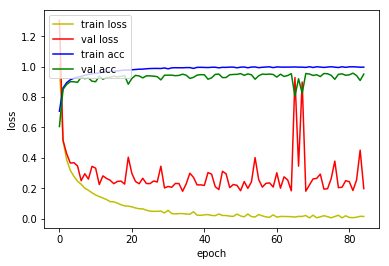

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2356 - acc: 0.9350
Loss: 0.23555388354066747 Accuracy: 0.9349948

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7990 - acc: 0.7676
Epoch 00001: val_loss improved from inf to 0.72652, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_BN_7_conv_checkpoint/001-0.7265.hdf5
36805/36805 [==============================] - 123s 3ms/sample - loss: 0.7989 - acc: 0.7676 - val_loss: 0.7265 - val_acc: 0.7969
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3391 - acc: 0.9043
Epoch 00002: val_loss improved from 0.72652 to 0.33230, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_BN_7_conv_checkpoint/002-0.3323.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.3391 - acc: 0.9043 - val_loss: 0.3323 - val_acc: 0.9068
Epoch 3/500
36800/36805 [===========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0166 - acc: 0.9965
Epoch 00027: val_loss did not improve from 0.14309
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0167 - acc: 0.9965 - val_loss: 0.1849 - val_acc: 0.9543
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0211 - acc: 0.9953
Epoch 00028: val_loss did not improve from 0.14309
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0212 - acc: 0.9953 - val_loss: 0.2017 - val_acc: 0.9513
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9920
Epoch 00029: val_loss did not improve from 0.14309
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0301 - acc: 0.9920 - val_loss: 0.1547 - val_acc: 0.9560
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0199 - acc: 0.9952
Epoch 00030: val_loss did not improve from 0.14309
36805/36805 [=====================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0070 - acc: 0.9986
Epoch 00056: val_loss did not improve from 0.12242
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0070 - acc: 0.9986 - val_loss: 0.1917 - val_acc: 0.9539
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9969
Epoch 00057: val_loss did not improve from 0.12242
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0104 - acc: 0.9969 - val_loss: 0.1724 - val_acc: 0.9578
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.9993
Epoch 00058: val_loss did not improve from 0.12242
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0045 - acc: 0.9993 - val_loss: 0.2467 - val_acc: 0.9471
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0060 - acc: 0.9988
Epoch 00059: val_loss did not improve from 0.12242
36805/36805 [========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0139 - acc: 0.9961
Epoch 00086: val_loss did not improve from 0.12242
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0139 - acc: 0.9961 - val_loss: 0.1510 - val_acc: 0.9627
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0019 - acc: 0.9998
Epoch 00087: val_loss did not improve from 0.12242
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0019 - acc: 0.9998 - val_loss: 0.1431 - val_acc: 0.9644
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0085 - acc: 0.9979
Epoch 00088: val_loss did not improve from 0.12242
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0085 - acc: 0.9979 - val_loss: 0.1429 - val_acc: 0.9653
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0019 - acc: 0.9996
Epoch 00089: val_loss did not improve from 0.12242
36805/36805 [========

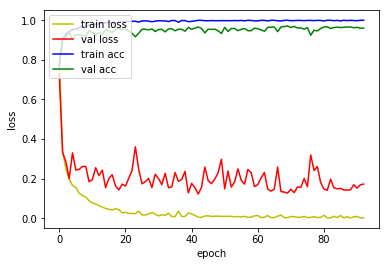

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1605 - acc: 0.9549
Loss: 0.16049782080248942 Accuracy: 0.9549325

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7484 - acc: 0.7750
Epoch 00001: val_loss improved from inf to 0.71903, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_BN_8_conv_checkpoint/001-0.7190.hdf5
36805/36805 [==============================] - 129s 4ms/sample - loss: 0.7483 - acc: 0.7751 - val_loss: 0.7190 - val_acc: 0.7778
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2989 - acc: 0.9095
Epoch 00002: val_loss improved from 0.71903 to 0.32233, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_BN_8_conv_checkpoint/002-0.3223.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.2989 - acc: 0.9095 - val_loss: 0.3223 - val_acc: 0.9001
Epoch 3/500
36800/36805 [===========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0159 - acc: 0.9961
Epoch 00027: val_loss did not improve from 0.14425
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0159 - acc: 0.9961 - val_loss: 0.1721 - val_acc: 0.9546
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0141 - acc: 0.9964
Epoch 00028: val_loss did not improve from 0.14425
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0141 - acc: 0.9964 - val_loss: 0.1786 - val_acc: 0.9546
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0131 - acc: 0.9969
Epoch 00029: val_loss did not improve from 0.14425
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0131 - acc: 0.9969 - val_loss: 0.2220 - val_acc: 0.9453
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0139 - acc: 0.9967
Epoch 00030: val_loss did not improve from 0.14425
36805/36805 [=====================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.9988
Epoch 00056: val_loss did not improve from 0.13532
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0048 - acc: 0.9988 - val_loss: 0.1962 - val_acc: 0.9539
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0117 - acc: 0.9964
Epoch 00057: val_loss did not improve from 0.13532
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0118 - acc: 0.9964 - val_loss: 0.1955 - val_acc: 0.9616
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0096 - acc: 0.9971
Epoch 00058: val_loss did not improve from 0.13532
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0096 - acc: 0.9971 - val_loss: 0.1496 - val_acc: 0.9632
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0042 - acc: 0.9993
Epoch 00059: val_loss did not improve from 0.13532
36805/36805 [========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0095 - acc: 0.9970
Epoch 00086: val_loss did not improve from 0.13532
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0095 - acc: 0.9970 - val_loss: 0.1387 - val_acc: 0.9683
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0065 - acc: 0.9983
Epoch 00087: val_loss did not improve from 0.13532
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0065 - acc: 0.9983 - val_loss: 0.1385 - val_acc: 0.9660
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 0.9997
Epoch 00088: val_loss did not improve from 0.13532
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0015 - acc: 0.9997 - val_loss: 0.1436 - val_acc: 0.9637
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0014 - acc: 0.9998
Epoch 00089: val_loss did not improve from 0.13532
36805/36805 [========

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 9.1669e-04 - acc: 0.9999
Epoch 00115: val_loss did not improve from 0.12233
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0011 - acc: 0.9998 - val_loss: 0.1425 - val_acc: 0.9690
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9979
Epoch 00116: val_loss did not improve from 0.12233
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0075 - acc: 0.9979 - val_loss: 0.1486 - val_acc: 0.9688
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0069 - acc: 0.9981
Epoch 00117: val_loss did not improve from 0.12233
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0070 - acc: 0.9981 - val_loss: 0.1783 - val_acc: 0.9620
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0042 - acc: 0.9989
Epoch 00118: val_loss did not improve from 0.12233
36805/36805 [

36800/36805 [============================>.] - ETA: 0s - loss: 0.0062 - acc: 0.9983
Epoch 00144: val_loss did not improve from 0.12233
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0062 - acc: 0.9983 - val_loss: 0.1942 - val_acc: 0.9616
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 0.9992
Epoch 00145: val_loss did not improve from 0.12233
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0025 - acc: 0.9992 - val_loss: 0.1618 - val_acc: 0.9676
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0013 - acc: 0.9997
Epoch 00146: val_loss did not improve from 0.12233
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0013 - acc: 0.9997 - val_loss: 0.1614 - val_acc: 0.9665
Epoch 147/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0049 - acc: 0.9990
Epoch 00147: val_loss did not improve from 0.12233
36805/36805 [==================

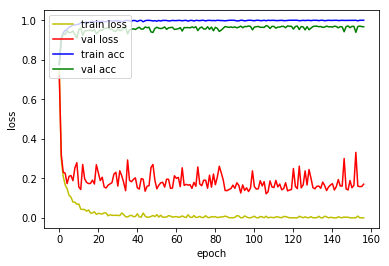

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1889 - acc: 0.9605
Loss: 0.18888087004397996 Accuracy: 0.96054



In [10]:
base = '1D_CNN_custom_multi_2_GAP_ch_128_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GAP_ch_128_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GAP_ch_128_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 128)   512         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_39[0][0]  
___________________________________________________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.6988 - acc: 0.8019
Loss: 0.6988116537299112 Accuracy: 0.80186915

1D_CNN_custom_multi_2_GAP_ch_128_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 128)   512         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activatio

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2356 - acc: 0.9350
Loss: 0.23555388354066747 Accuracy: 0.9349948

1D_CNN_custom_multi_2_GAP_ch_128_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 128)   512         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activatio

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1889 - acc: 0.9605
Loss: 0.18888087004397996 Accuracy: 0.96054


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_GAP_ch_128_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 128)   512         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_39[0][0]  
___________________________________________________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.0139 - acc: 0.7512
Loss: 1.013915139152006 Accuracy: 0.7511942

1D_CNN_custom_multi_2_GAP_ch_128_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 128)   512         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2584 - acc: 0.9425
Loss: 0.2583670324238785 Accuracy: 0.94247144

1D_CNN_custom_multi_2_GAP_ch_128_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 128)   512         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activatio

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.1990 - acc: 0.9572
Loss: 0.19897295174348242 Accuracy: 0.95721704
